In [22]:
import torch 
import torch_geometric
import tigramite
import numpy as np 
#from scipy.sparse import csr_matrix
import networkx as nx

In [21]:
from torch_geometric.datasets import BA2MotifDataset

motif_dataset = BA2MotifDataset(root = '/Users/omkarnaik/CI-GNN/Motif_data')

In [1002]:
motif_dataset.data

Data(x=[25000, 10], edge_index=[2, 50960], y=[1000])

In [1138]:
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root= '/Users/omkarnaik/CI-GNN/Data',name = 'MUTAG' )

In [1143]:
dataset[0].x.size(1)

In [881]:
random_split_flag = True 
from torch.utils.data import random_split,Subset
from torch_geometric.loader import DataLoader
data_split_ratio = [0.8, 0.1, 0.1]
seed= 0
batch_size = 32
if not random_split_flag and hasattr(dataset, 'supplement'):
        assert 'split_indices' in dataset.supplement.keys(), "split idx"
        split_indices = dataset.supplement['split_indices']
        train_indices = torch.where(split_indices == 0)[0].numpy().tolist()
        dev_indices = torch.where(split_indices == 1)[0].numpy().tolist()
        test_indices = torch.where(split_indices == 2)[0].numpy().tolist()

        train = Subset(dataset, train_indices)
        eval = Subset(dataset, dev_indices)
        test = Subset(dataset, test_indices)
else:
        num_train = int(data_split_ratio[0] * len(dataset))
        num_eval = int(data_split_ratio[1] * len(dataset))
        num_test = len(dataset) - num_train - num_eval

        train, eval, test = random_split(dataset, lengths=[num_train, num_eval, num_test],
                                        generator=torch.Generator().manual_seed(seed))
num_eval = len(eval)
num_test = len(test)
dataloader = dict()
dataloader['train'] = DataLoader(train, batch_size=batch_size, shuffle=True)
dataloader['eval'] = DataLoader(eval, batch_size=num_eval, shuffle=False)

In [882]:
dataloader

{'train': <torch_geometric.loader.dataloader.DataLoader at 0x162b51710>,
 'eval': <torch_geometric.loader.dataloader.DataLoader at 0x1629bdb10>}

In [23]:
device = 'cpu'

import networkx as nx 

from torch_geometric.utils import to_networkx
G = []
for graph in motif_dataset: 
    g = to_networkx(graph)
    G.append(g)

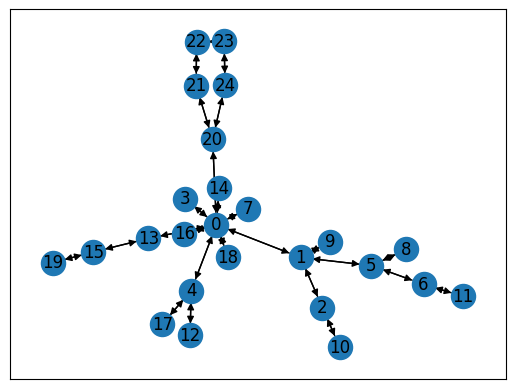

In [24]:
G
import matplotlib
nx.draw_networkx(G[0] , with_labels  = True)

In [885]:
data = dataset[0]
print(data.y)

tensor([1])


In [886]:
data

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])

In [887]:
attributes = nx.get_node_attributes(G[0], name = '0')

In [888]:
attributes

In [889]:
G[0].nodes.data()

NodeDataView({0: {}, 1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}, 10: {}, 11: {}, 12: {}, 13: {}, 14: {}, 15: {}, 16: {}, 17: {}, 18: {}, 19: {}, 20: {}, 21: {}, 22: {}, 23: {}, 24: {}})

In [890]:
dataset.x

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]], dtype=torch.float32)

In [891]:
adjacency_matrix = nx.adjacency_matrix(G[0])

In [892]:
adjacency_matrix

<Compressed Sparse Row sparse array of dtype 'int64'
	with 50 stored elements and shape (25, 25)>

In [893]:
G

In [25]:
import torch.nn as nn 
import torch.nn.functional as F 
from torch_geometric.nn import GCNConv

class GNNModel(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super(GNNModel,self).__init__()
        self.conv1 = GCNConv(in_channels, 2*hidden_channels)
        self.conv2 = GCNConv(2*hidden_channels , hidden_channels)
        self.conv3 = GCNConv(hidden_channels, 2* hidden_channels)
        self.conv4 = GCNConv(2* hidden_channels, hidden_channels )
        self.conv5 = GCNConv(hidden_channels, 1)
    
    def forward(self,x,edge_index):
        x = self.conv1(x,edge_index)
        x = F.leaky_relu(x)
        x = self.conv2(x,edge_index)
        x = F.leaky_relu(x)
        x = F.dropout(x)
        x = self.conv3(x,edge_index)
        x = F.leaky_relu(x)
        x = F.dropout(x)
        x = self.conv4(x,edge_index)
        x = self.conv5(x,edge_index)
        x = F.leaky_relu(x)
        return x



In [895]:
dataset[0].x.dtype

torch.float32

In [26]:
node_representation = []
input_channels = 10
hidden_channels = 64

model = GNNModel(input_channels, hidden_channels)
max_nodes = 25
model = model.float()
for graph in motif_dataset :
    with torch.no_grad():
        rep = model(graph.x, graph.edge_index)
        padded_rep = F.pad(rep,(0,0,0,max_nodes - rep.size(0)))
        node_representation.append(padded_rep)

In [905]:
node = node_representation[0].reshape(-1)

In [906]:
node_representation[0].shape

torch.Size([25, 1])

In [907]:
node 

tensor([-0.0754, -0.0322, -0.0522, -0.0210, -0.0150, -0.0407, -0.0266, -0.0035,
        -0.0357, -0.0080, -0.0468, -0.0144,  0.0018, -0.0645, -0.0420, -0.0809,
        -0.0146, -0.0311, -0.0257, -0.0634, -0.0381, -0.0315, -0.0145, -0.0341,
        -0.0523], dtype=torch.float32)

In [27]:
graph_data = [rep.reshape(-1) for rep in node_representation]

In [7]:
graph_data

[tensor([-1.5966e-04, -4.3119e-04, -1.6006e-04, -1.1629e-04, -1.4244e-05,
         -2.9663e-04, -3.4247e-05, -6.1939e-05, -2.6792e-04, -4.7130e-04,
         -5.2011e-05,  7.7245e-03,  5.1580e-03, -1.6466e-04, -5.7611e-05,
         -2.7764e-04,  4.9931e-03, -7.6834e-05,  1.8765e-03, -2.8406e-04,
         -1.2431e-05, -4.0933e-05, -1.2023e-06, -9.2184e-06, -6.8513e-06]),
 tensor([-2.6628e-04, -1.4547e-04, -5.8880e-06, -1.1756e-04, -3.5450e-05,
         -1.6500e-05, -1.0755e-04, -1.3840e-04, -3.2993e-05,  1.8758e-02,
         -2.1063e-04, -9.4900e-05, -2.5976e-05, -1.3445e-04, -1.7594e-05,
         -9.7306e-05, -1.1713e-04,  2.6185e-02, -7.8527e-05, -2.4003e-04,
         -7.5471e-06,  5.7547e-03,  3.5508e-03, -3.9026e-05, -8.2025e-05]),
 tensor([-1.2381e-04, -2.3166e-04, -4.3889e-04,  2.4108e-03,  1.6849e-02,
         -2.2261e-04,  4.8553e-03, -2.2689e-04,  2.2734e-02, -7.7681e-05,
          4.7110e-03, -1.6894e-04, -8.8408e-05,  2.0612e-02, -1.7200e-04,
         -1.5978e-04,  1.7217e-02,

In [28]:
import pandas as pd 
dataframe = pd.DataFrame(graph_data)

In [9]:
dataframe

0                    1                    2   \
0        tensor(-0.0002)      tensor(-0.0004)      tensor(-0.0002)   
1        tensor(-0.0003)      tensor(-0.0001)  tensor(-5.8880e-06)   
2        tensor(-0.0001)      tensor(-0.0002)      tensor(-0.0004)   
3    tensor(-9.9154e-05)      tensor(-0.0006)      tensor(-0.0005)   
4        tensor(-0.0002)      tensor(-0.0002)      tensor(-0.0004)   
..                   ...                  ...                  ...   
995      tensor(-0.0001)      tensor(-0.0004)      tensor(-0.0003)   
996      tensor(-0.0001)       tensor(0.0017)      tensor(-0.0002)   
997      tensor(-0.0005)      tensor(-0.0002)      tensor(-0.0001)   
998       tensor(0.0095)  tensor(-4.5927e-05)   tensor(7.6737e-05)   
999      tensor(-0.0003)      tensor(-0.0003)      tensor(-0.0003)   

                  3                    4                    5   \
0    tensor(-0.0001)  tensor(-1.4244e-05)      tensor(-0.0003)   
1    tensor(-0.0001)  tensor(-3.5450e-05)  tensor(-1.6500e-05)   
2     tensor(0.0024)       tensor(0.0168)      tensor(-0.0002)   
3    tensor(-0.0004)       tensor(0.0020)      tensor(-0.0002)   
4    tensor(-0.0001)      tensor(-0.0002)      tensor(-0.0003)   
..               ...                  ...                  ...   
995  tensor(-0.0001)      tensor(-0.0003)       tensor(0.0077)   
996  tensor(-0.0001)      tensor(-0.0001)      tensor(-0.0002)   
997  tensor(-0.0002)  tensor(-7.8061e-05)      tensor(-0.0002)   
998   tensor(0.0020)      tensor(-0.0001)       tensor(0.0055)   
999  tensor(-0.0003)      tensor(-0.0004)      tensor(-0.0002)   

                      6                    7                    8   \
0    tensor(-3.4247e-05)  tensor(-6.1939e-05)      tensor(-0.0003)   
1        tensor(-0.0001)      tensor(-0.0001)  tensor(-3.2993e-05)   
2         tensor(0.0049)      tensor(-0.0002)       tensor(0.0227)   
3        tensor(-0.0004)       tensor(0.0051)      tensor(-0.0003)   
4        tensor(-0.0002)      tensor(-0.0002)      tensor(-0.0003)   
..                   ...                  ...                  ...   
995       tensor(0.0016)       tensor(0.0045)      tensor(-0.0002)   
996      tensor(-0.0001)      tensor(-0.0002)  tensor(-4.1651e-06)   
997      tensor(-0.0002)      tensor(-0.0001)      tensor(-0.0002)   
998       tensor(0.0035)  tensor(-1.9960e-06)  tensor(-5.7695e-05)   
999  tensor(-7.8146e-05)      tensor(-0.0001)      tensor(-0.0005)   

                      9   ...                   15                   16  \
0        tensor(-0.0005)  ...      tensor(-0.0003)       tensor(0.0050)   
1         tensor(0.0188)  ...  tensor(-9.7306e-05)      tensor(-0.0001)   
2    tensor(-7.7681e-05)  ...      tensor(-0.0002)       tensor(0.0172)   
3        tensor(-0.0006)  ...      tensor(-0.0002)       tensor(0.0137)   
4        tensor(-0.0002)  ...      tensor(-0.0001)  tensor(-3.4436e-05)   
..                   ...  ...                  ...                  ...   
995      tensor(-0.0002)  ...  tensor(-7.2526e-05)      tensor(-0.0001)   
996      tensor(-0.0002)  ...  tensor(-9.6970e-05)      tensor(-0.0001)   
997  tensor(-5.9982e-06)  ...       tensor(0.0029)  tensor(-5.5773e-05)   
998       tensor(0.0064)  ...  tensor(-5.5089e-05)  tensor(-4.3817e-05)   
999      tensor(-0.0003)  ...  tensor(-6.0606e-05)      tensor(-0.0003)   

                      17                   18                   19  \
0    tensor(-7.6834e-05)       tensor(0.0019)      tensor(-0.0003)   
1         tensor(0.0262)  tensor(-7.8527e-05)      tensor(-0.0002)   
2         tensor(0.0074)       tensor(0.0246)      tensor(-0.0004)   
3        tensor(-0.0006)      tensor(-0.0003)      tensor(-0.0003)   
4         tensor(0.0028)      tensor(-0.0001)      tensor(-0.0002)   
..                   ...                  ...                  ...   
995  tensor(-9.2795e-05)  tensor(-9.7473e-05)      tensor(-0.0002)   
996      tensor(-0.0002)      tensor(-0.0001)  tensor(-5.8476e-05)   
997      tensor(

In [ ]:
node_representation[2].shape

torch.Size([28, 4])

In [ ]:
dataset[0].x.shape

torch.Size([17, 7])

In [ ]:
node_representation[0]

tensor([[ 0.3545, -0.1547,  0.0329, -0.4581],
        [ 0.3545, -0.1547,  0.0329, -0.4581],
        [ 0.3424, -0.1495,  0.0318, -0.4425],
        [ 0.3830, -0.1672,  0.0355, -0.4950],
        [ 0.3888, -0.1697,  0.0361, -0.5025],
        [ 0.3464, -0.1512,  0.0321, -0.4477],
        [ 0.3411, -0.1489,  0.0316, -0.4408],
        [ 0.3411, -0.1489,  0.0316, -0.4408],
        [ 0.3842, -0.1677,  0.0356, -0.4965],
        [ 0.3830, -0.1672,  0.0355, -0.4950],
        [ 0.3371, -0.1471,  0.0313, -0.4356],
        [ 0.3183, -0.1441,  0.0327, -0.4079],
        [ 0.3291, -0.1971,  0.0636, -0.3903],
        [ 0.3102, -0.1406,  0.0320, -0.3975],
        [ 0.2377, -0.2447,  0.1077, -0.2171],
        [ 0.1546, -0.1985,  0.0944, -0.1155],
        [ 0.1546, -0.1985,  0.0944, -0.1155],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000

In [ ]:
node_representation[0].shape

torch.Size([17, 1])

In [ ]:
len(node_representation)

188

In [898]:
motif_dataset[0].

AttributeError: 'GlobalStorage' object has no attribute 'get_summary'

In [902]:
max_nodes = max(graph.shape[0] for graph in node_representation)

In [903]:
max_nodes

In [161]:
node_representation[0].shape[0]

17

In [29]:
dataframe['X26'] = motif_dataset.y

In [30]:
dataframe.head()

0               1               2               3  \
0  tensor(0.0554)  tensor(0.0639)  tensor(0.0631)  tensor(0.0351)   
1  tensor(0.0151)  tensor(0.0102)  tensor(0.0055)  tensor(0.0046)   
2  tensor(0.0499)  tensor(0.0339)  tensor(0.0336)  tensor(0.0403)   
3  tensor(0.0499)  tensor(0.0464)  tensor(0.0147)  tensor(0.0109)   
4  tensor(0.0041)  tensor(0.0276)  tensor(0.0282)  tensor(0.0249)   

                4                    5               6               7  \
0  tensor(0.0305)       tensor(0.0402)  tensor(0.0019)  tensor(0.0243)   
1  tensor(0.0301)       tensor(0.0331)  tensor(0.0058)  tensor(0.0105)   
2  tensor(0.0776)  tensor(-2.3607e-05)  tensor(0.0488)  tensor(0.0306)   
3  tensor(0.0406)       tensor(0.0010)  tensor(0.0134)  tensor(0.0189)   
4  tensor(0.0163)       tensor(0.0187)  tensor(0.0191)  tensor(0.0281)   

                     8                    9  ...              16  \
0       tensor(0.0377)       tensor(0.0415)  ...  tensor(0.0141)   
1  tensor(-1.0648e-06)  tensor(-4.6652e-05)  ...  tensor(0.0039)   
2       tensor(0.0300)       tensor(0.0236)  ...  tensor(0.0156)   
3       tensor(0.0057)       tensor(0.0287)  ...  tensor(0.0043)   
4       tensor(0.0220)       tensor(0.0174)  ...  tensor(0.0017)   

                    17              18                   19  \
0       tensor(0.0230)  tensor(0.0273)  tensor(-9.7851e-05)   
1  tensor(-6.1566e-05)  tensor(0.0023)       tensor(0.0215)   
2       tensor(0.0415)  tensor(0.0479)       tensor(0.0240)   
3       tensor(0.0297)  tensor(0.0259)       tensor(0.0057)   
4       tensor(0.0031)  tensor(0.0128)       tensor(0.0148)   

                    20              21              22              23  \
0       tensor(0.0285)  tensor(0.0217)  tensor(0.0238)  tensor(0.0273)   
1       tensor(0.0115)  tensor(0.0105)  tensor(0.0163)  tensor(0.0200)   
2       tensor(0.0242)  tensor(0.0152)  tensor(0.0160)  tensor(0.0149)   
3       tensor(0.0506)  tensor(0.0293)  tensor(0.0258)  tensor(0.0354)   
4  tensor(-6.3740e-05)  tensor(0.0006)  tensor(0.0102)  tensor(0.0089)   

               24 X26  
0  tensor(0.0256)   0  
1  tensor(0.0162)   0  
2  tensor(0.0137)   0  
3  tensor(0.0475)   0  
4  tensor(0.0006)   0  

[5 rows x 26 columns]

In [12]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 26 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       1000 non-null   object
 1   1       1000 non-null   object
 2   2       1000 non-null   object
 3   3       1000 non-null   object
 4   4       1000 non-null   object
 5   5       1000 non-null   object
 6   6       1000 non-null   object
 7   7       1000 non-null   object
 8   8       1000 non-null   object
 9   9       1000 non-null   object
 10  10      1000 non-null   object
 11  11      1000 non-null   object
 12  12      1000 non-null   object
 13  13      1000 non-null   object
 14  14      1000 non-null   object
 15  15      1000 non-null   object
 16  16      1000 non-null   object
 17  17      1000 non-null   object
 18  18      1000 non-null   object
 19  19      1000 non-null   object
 20  20      1000 non-null   object
 21  21      1000 non-null   object
 22  22      1000 non-null   o

In [31]:
for col in dataframe.columns : 
    dataframe[col] = dataframe[col].astype(float)

In [14]:
dataframe.head()

0         1         2         3         4         5         6  \
0 -0.000160 -0.000431 -0.000160 -0.000116 -0.000014 -0.000297 -0.000034   
1 -0.000266 -0.000145 -0.000006 -0.000118 -0.000035 -0.000016 -0.000108   
2 -0.000124 -0.000232 -0.000439  0.002411  0.016849 -0.000223  0.004855   
3 -0.000099 -0.000566 -0.000482 -0.000368  0.002002 -0.000223 -0.000383   
4 -0.000156 -0.000186 -0.000355 -0.000114 -0.000226 -0.000276 -0.000187   

          7         8         9  ...        16        17        18        19  \
0 -0.000062 -0.000268 -0.000471  ...  0.004993 -0.000077  0.001876 -0.000284   
1 -0.000138 -0.000033  0.018758  ... -0.000117  0.026185 -0.000079 -0.000240   
2 -0.000227  0.022734 -0.000078  ...  0.017217  0.007375  0.024621 -0.000374   
3  0.005093 -0.000283 -0.000598  ...  0.013676 -0.000568 -0.000295 -0.000349   
4 -0.000248 -0.000328 -0.000172  ... -0.000034  0.002806 -0.000105 -0.000176   

         20        21        22        23        24  X26  
0 -0.000012 -0.000041 -0.000001 -0.000009 -0.000007  0.0  
1 -0.000008  0.005755  0.003551 -0.000039 -0.000082  0.0  
2 -0.000089 -0.000079 -0.000115 -0.000117 -0.000076  0.0  
3 -0.000280 -0.000191 -0.000098 -0.000091 -0.000164  0.0  
4 -0.000042 -0.000022  0.002244  0.004442  0.001518  0.0  

[5 rows x 26 columns]

In [15]:
dataframe.describe()

0            1            2            3            4  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean      0.001063     0.001400     0.001272     0.001406     0.001201   
std       0.004389     0.005283     0.004192     0.004419     0.004120   
min      -0.000790    -0.000739    -0.000656    -0.000661    -0.000573   
25%      -0.000247    -0.000266    -0.000217    -0.000205    -0.000204   
50%      -0.000147    -0.000153    -0.000120    -0.000116    -0.000120   
75%      -0.000052    -0.000048    -0.000036    -0.000025    -0.000032   
max       0.048959     0.051480     0.037105     0.048470     0.035847   

                 5            6            7            8            9  ...  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000  ...   
mean      0.001724     0.001714     0.001608     0.001550     0.001492  ...   
std       0.004927     0.004847     0.004780     0.004705     0.004590  ...   
min      -0.000584    -0.000570    -0.000542    -0.000701    -0.000598  ...   
25%      -0.000196    -0.000192    -0.000193    -0.000195    -0.000205  ...   
50%      -0.000099    -0.000096    -0.000102    -0.000112    -0.000116  ...   
75%      -0.000014    -0.000008    -0.000016    -0.000020    -0.000020  ...   
max       0.041373     0.043122     0.047046     0.038812     0.041303  ...   

                16           17           18            19           20  \
count  1000.000000  1000.000000  1000.000000  1.000000e+03  1000.000000   
mean      0.001611     0.002024     0.001797  1.877586e-03     0.000969   
std       0.004643     0.005881     0.005083  5.141833e-03     0.003300   
min      -0.000552    -0.000587    -0.000561 -5.609373e-04    -0.000616   
25%      -0.000186    -0.000175    -0.000180 -1.722980e-04    -0.000217   
50%      -0.000105    -0.000090    -0.000088 -8.852683e-05    -0.000127   
75%      -0.000013    -0.000007    -0.000008 -5.122328e-07    -0.000043   
max       0.049306     0.042741     0.039705  4.731002e-02     0.021929   

                21           22           23           24         X26  
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.00000  
mean      0.001422     0.001505     0.001476     0.001457     0.50000  
std       0.004046     0.004358     0.004479     0.004003     0.50025  
min      -0.000592    -0.000564    -0.000475    -0.000554     0.00000  
25%      -0.000202    -0.000208    -0.000197    -0.000186     0.00000  
50%      -0.000112    -0.000101    -0.000099    -0.000103     0.50000  
75%      -0.000017    -0.000016    -0.000018    -0.000016     1.00000  
max       0.028849     0.035975     0.036668     0.026592     1.00000  

[8 rows x 26 columns]

In [918]:
from causallearn.search.ConstraintBased.FCI import fci 

In [1107]:
from causallearn.search.ConstraintBased.PC import pc 

In [1130]:
cg_pc, edges = fci(dataframe.to_numpy())

  0%|          | 0/29 [00:00<?, ?it/s]

Depth=0, working on node 28: 100%|██████████| 29/29 [00:00<00:00, 107.25it/s]


X3 --> X1
X1 --> X6
X3 --> X2
X4 --> X3
X5 --> X4
X6 --> X5
X21 --> X22
X23 --> X24
X24 --> X25
X24 --> X26


In [1136]:
cg_pc.graph

array([[ 0,  2,  1,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 2,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [-1, -1,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, -1,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, -1,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  0, -1,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  2,  0,  2,  0,  0,  0,  0,  0,  0,  

In [1125]:
int_adj

In [1043]:
sample_data = dataframe[:100]

In [1045]:
sample_data.describe()

0           1           2           3           4           5  \
count  100.000000  100.000000  100.000000  100.000000  100.000000  100.000000   
mean     0.031401    0.034766    0.028544    0.026143    0.028125    0.027965   
std      0.018845    0.021460    0.017846    0.016788    0.019620    0.018119   
min     -0.000128   -0.000069   -0.000117   -0.000143   -0.000209   -0.000136   
25%      0.019873    0.019883    0.016124    0.013400    0.014371    0.018775   
50%      0.029516    0.035701    0.028837    0.024191    0.023590    0.026559   
75%      0.043812    0.044987    0.039812    0.036885    0.038245    0.038167   
max      0.111930    0.102470    0.070434    0.071343    0.103250    0.093809   

                6           7           8           9  ...          16  \
count  100.000000  100.000000  100.000000  100.000000  ...  100.000000   
mean     0.023148    0.023261    0.020981    0.024206  ...    0.021484   
std      0.015297    0.019151    0.015672    0.016685  ...    0.015559   
min     -0.000135   -0.000139   -0.000169   -0.000161  ...   -0.000108   
25%      0.013963    0.008445    0.009623    0.011608  ...    0.008469   
50%      0.020428    0.019750    0.019145    0.023262  ...    0.019930   
75%      0.032481    0.033134    0.027504    0.034513  ...    0.029104   
max      0.065929    0.085825    0.076955    0.070729  ...    0.065246   

               17          18          19          20          21          22  \
count  100.000000  100.000000  100.000000  100.000000  100.000000  100.000000   
mean     0.019204    0.018927    0.021026    0.026905    0.022681    0.024545   
std      0.014386    0.013754    0.016329    0.015501    0.015753    0.017613   
min     -0.000229   -0.000169   -0.000223   -0.000147   -0.000174   -0.000207   
25%      0.006596    0.007139    0.009868    0.016450    0.010721    0.011802   
50%      0.017943    0.018037    0.017774    0.026931    0.020695    0.022496   
75%      0.028807    0.026200    0.028450    0.035849    0.031831    0.036517   
max      0.063619    0.055505    0.082939    0.076278    0.063829    0.070791   

               23          24    X26  
count  100.000000  100.000000  100.0  
mean     0.026287    0.025499    0.0  
std      0.017343    0.015764    0.0  
min     -0.000101   -0.000066    0.0  
25%      0.014870    0.014328    0.0  
50%      0.022899    0.024131    0.0  
75%      0.038310    0.037338    0.0  
max      0.072085    0.068294    0.0  

[8 rows x 26 columns]

In [32]:
from causallearn.search.FCMBased import lingam

model = lingam.ICALiNGAM(random_state=32, max_iter=2000)
model.fit(dataframe)

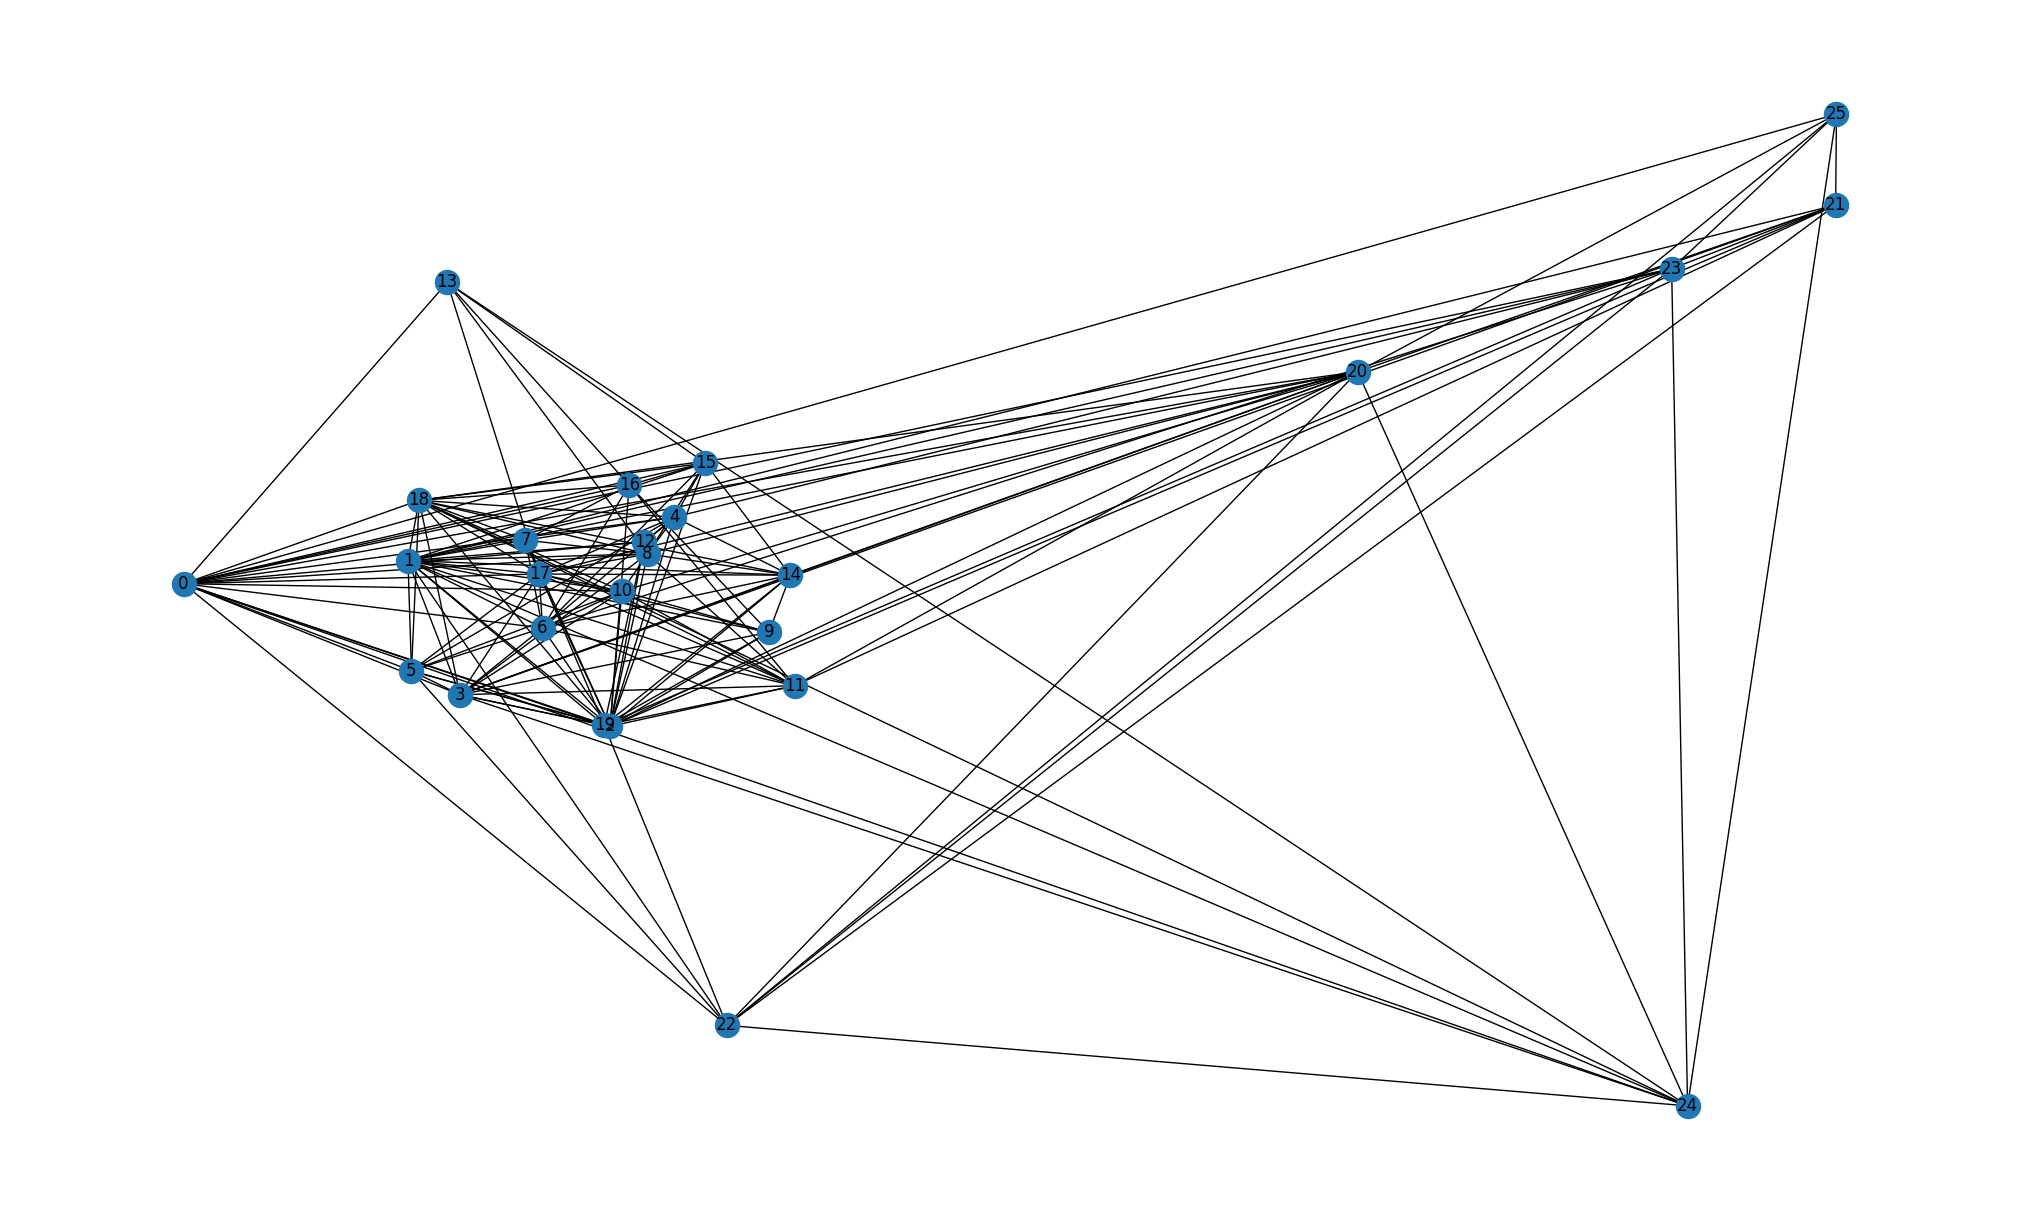

In [1061]:
graph_nx_l = nx.from_numpy_array(model.adjacency_matrix_)
import matplotlib.pyplot as plt
nx.draw(graph_nx_l, with_labels=True)
plt.show()

In [1067]:
l_edge_list = list(graph_nx_l.edges())

In [1097]:
graph_nx_l

In [1071]:
l_edge = np.array(l_edge_list)

In [1072]:
l_edge.shape

In [1054]:
print(model.adjacency_matrix_)

[[ 0.000e+00  0.000e+00  0.000e+00  1.041e-01  0.000e+00  0.000e+00
   0.000e+00  0.000e+00  1.003e-01  0.000e+00  8.329e-02  0.000e+00
   0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  1.646e-01
   1.888e-01  0.000e+00  1.214e+00  0.000e+00 -9.057e-01  6.100e-01
  -6.087e-01  0.000e+00]
 [ 0.000e+00  0.000e+00  1.079e-01  8.681e-02  0.000e+00  0.000e+00
   6.352e-02  0.000e+00  6.505e-02  8.703e-02  1.553e-01  8.176e-02
   0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  9.151e-02
   1.728e-01  0.000e+00  9.994e-01 -5.569e-01  3.097e-01 -3.019e-01
  -3.173e-01  0.000e+00]
 [ 5.037e-02  0.000e+00  0.000e+00  2.209e-01  0.000e+00  0.000e+00
   0.000e+00  0.000e+00  9.670e-02  0.000e+00  4.118e-02  0.000e+00
   0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  4.964e-02
   5.208e-02  0.000e+00  1.699e-01 -1.442e-01  0.000e+00  0.000e+00
   0.000e+00  0.000e+00]
 [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
   0.000e+00  0.000e+00  1.692e-01  0.000

In [1057]:
from causallearn.utils.GraphUtils import GraphUtils
pdy = GraphUtils.to_pydot(graph_nx_l)
pdy.write_png('fci_graph_new.png')


AttributeError: 'Graph' object has no attribute 'get_nodes'

In [940]:
from causallearn.utils.GraphUtils import GraphUtils
def adj_matrix(graph):
    return GraphUtils.to_numpy(graph)

In [ ]:
print(adj_matrix())

In [942]:
from causallearn.utils.GraphUtils import GraphUtils

lis = [101,201,301,401,501,601,701,801,901]

for i in range(len(lis)+1):
    if i == 0 :
        cg,edges = fci(dataframe[:lis[i]].to_numpy(), alpha = 0.5,show_progress=True)
    elif i < len(lis) : 
        cg,edge = fci(dataframe[lis[i-1]:lis[i]].to_numpy(), alpha = 0.5, show_progress=True,background_knowledge= background_info)
    else :
        cg,edge = fci(dataframe[901:].to_numpy(), alpha = 0.5, background_knowledge= background_info, show_progress=True)
    background_info = adj_matrix(cg)


invalid value encountered in divide
invalid value encountered in divide
































































































































































































































Depth=1, working on node 7:  31%|███       | 8/26 [12:01<27:03, 90.18s/it]


KeyboardInterrupt: 

In [1013]:
cg_2, edge = fci(dataframe.to_numpy(), alpha = 0.01, depth = 2)

Depth=0, working on node 5:  19%|█▉        | 5/26 [00:00<00:00, 339.47it/s]

Depth=0, working on node 25: 100%|██████████| 26/26 [00:00<00:00, 383.35it/s]


X4 --> X1
X1 --> X16
X21 --> X1
X6 --> X2
X7 --> X2
X3 --> X7
X14 --> X3
X16 --> X3
X7 --> X4
X17 --> X4
X20 --> X4
X8 --> X6
X6 --> X17
X8 --> X13
X14 --> X9
X11 --> X19
X13 --> X18
X18 --> X14
X25 --> X21


In [134]:
numpy_data = dataframe.to_numpy()

In [136]:
numpy_data.shape

In [946]:
cg.draw_pydot_graph()

AttributeError: 'GeneralGraph' object has no attribute 'draw_pydot_graph'

array([[<Axes: title={'center': 'X26'}>]], dtype=object)

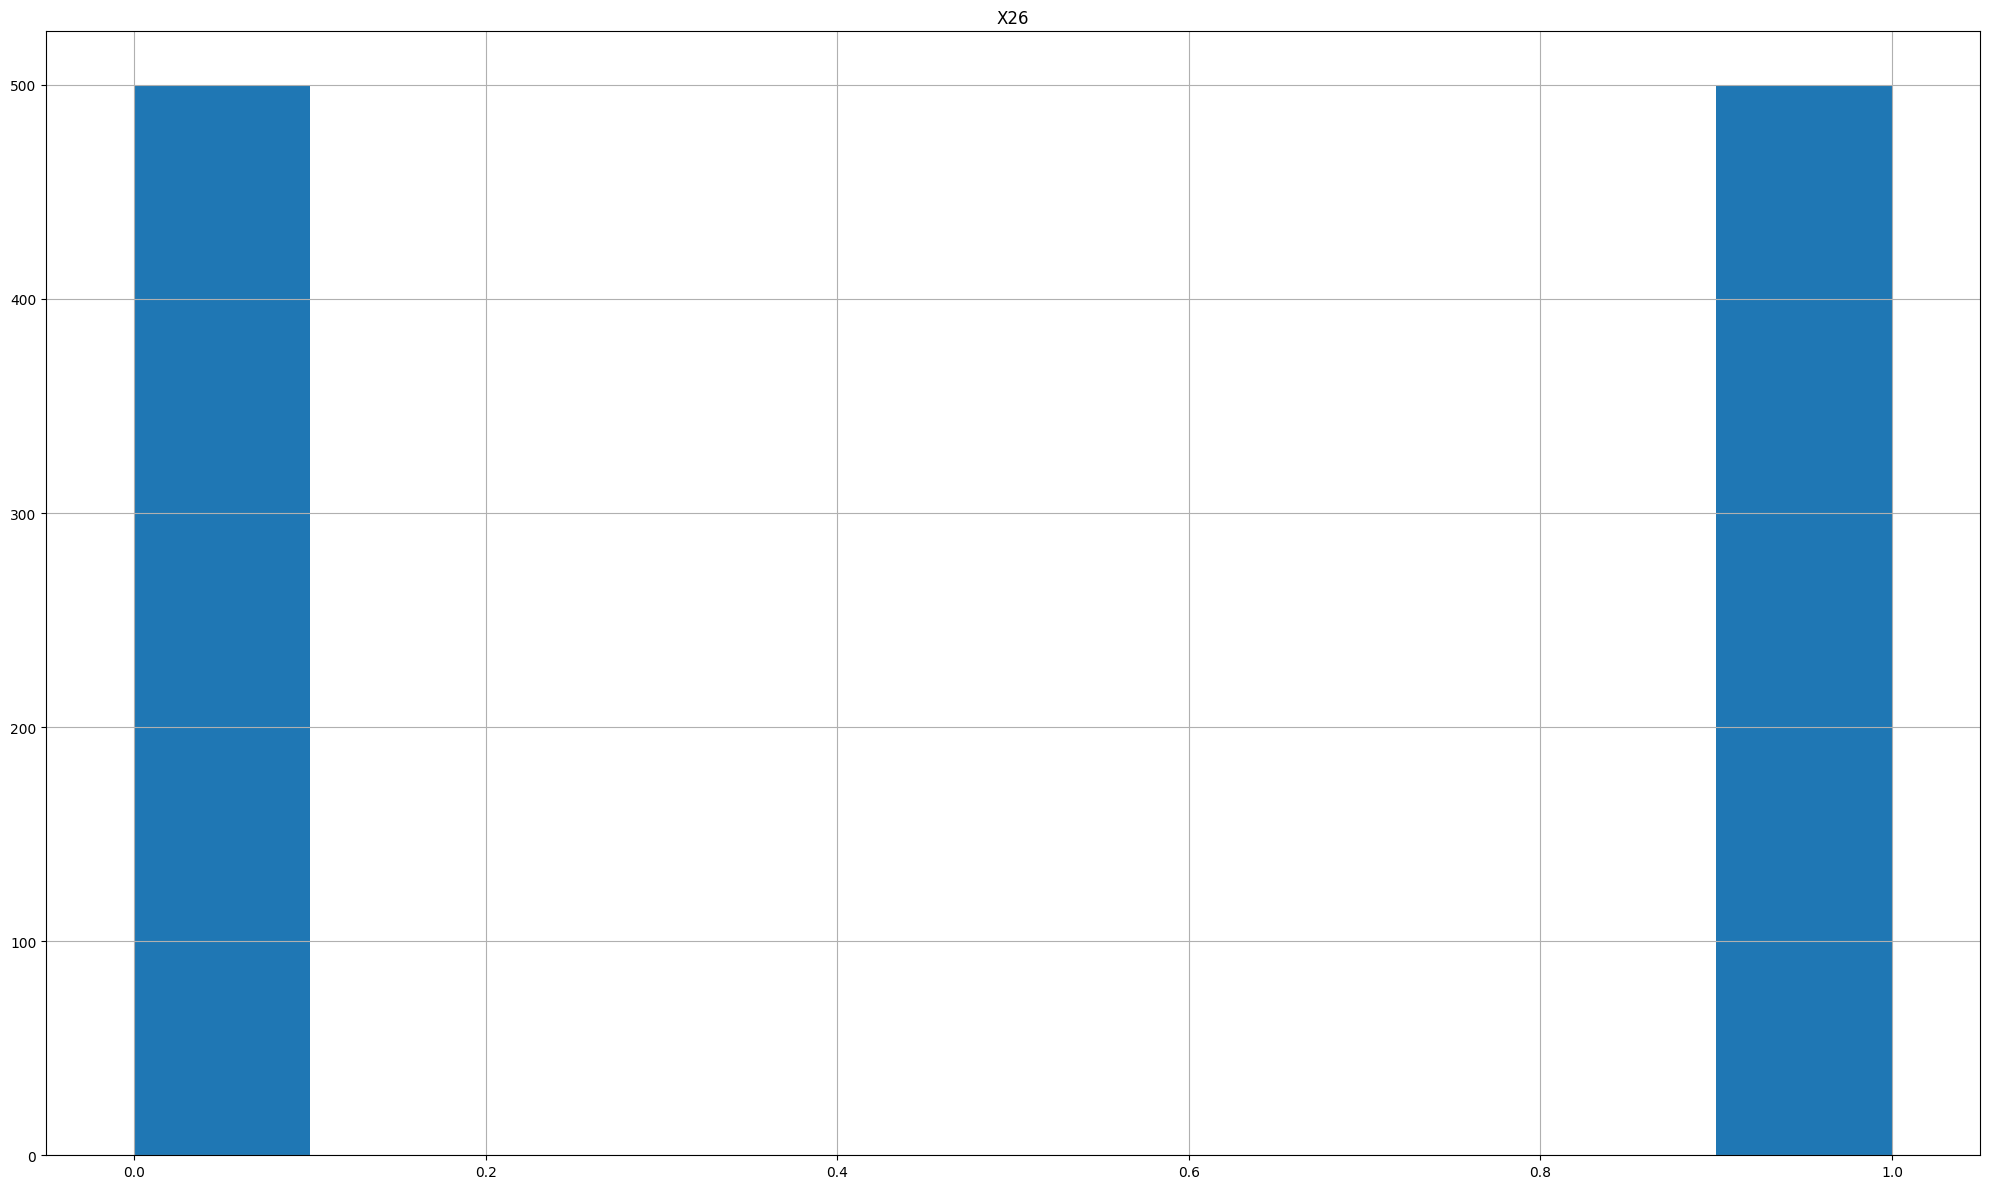

In [948]:
dataframe.hist('X26')

In [284]:
from causallearn.search.ConstraintBased.FCI import fci

g, edges = fci(dataframe.to_numpy(), independence_test_method= 'kci', alpha = 0.05)

from causallearn.utils.GraphUtils import GraphUtils
pdy = GraphUtils.to_pydot(g)
pdy.write_png('Causal_graph.png')


Depth=0, working on node 0:   0%|          | 0/29 [00:00<?, ?it/s]

Depth=0, working on node 28: 100%|██████████| 29/29 [00:00<00:00, 43.39it/s]


X7 --> X6
X8 --> X7
X9 --> X8
X10 --> X9
X11 --> X10
X12 --> X11


In [53]:
dataframe['Graph Label'].dtype

dtype('float64')

In [285]:
from sklearn.model_selection import train_test_split
x = dataframe.drop('Graph Label', axis = 1)
y = dataframe['Graph Label']

x_train,x_test,y_train,y_test = train_test_split(x,y, test_size = 0.2,random_state=32)



In [294]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score,recall_score
model = RandomForestClassifier(n_estimators = 100,criterion='entropy')

model.fit(x_train,y_train)

pred = model.predict(x_test)

print(accuracy_score(y_test,pred))
print(f1_score(y_test, pred))
print(recall_score(y_test, pred))


0.8421052631578947
0.8888888888888888
0.8888888888888888


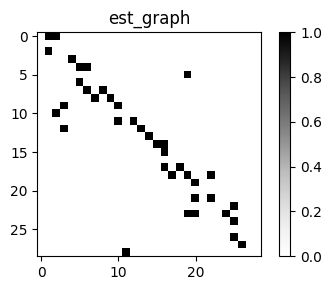

In [123]:
from castle.algorithms import PC
from castle.common import GraphDAG
pc = PC()

pc.learn(dataframe)

GraphDAG(pc.causal_matrix)

In [295]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Assume dataframe contains node features and graph label
# Separate features and label
features = dataframe.drop(columns=['Graph Label'])
labels = dataframe['Graph Label']

# Standardize the features
scaler = StandardScaler()
standardized_features = scaler.fit_transform(features)

# Recreate the standardized dataframe with graph label
standardized_dataframe = pd.DataFrame(standardized_features, columns=features.columns)
standardized_dataframe['Graph Label'] = labels.values

# Now you can pass standardized_dataframe for causal discovery


Depth=0, working on node 0:   3%|▎         | 1/29 [00:00<00:00, 428.43it/s]

Depth=3, working on node 28: 100%|██████████| 29/29 [00:00<00:00, 509.92it/s]


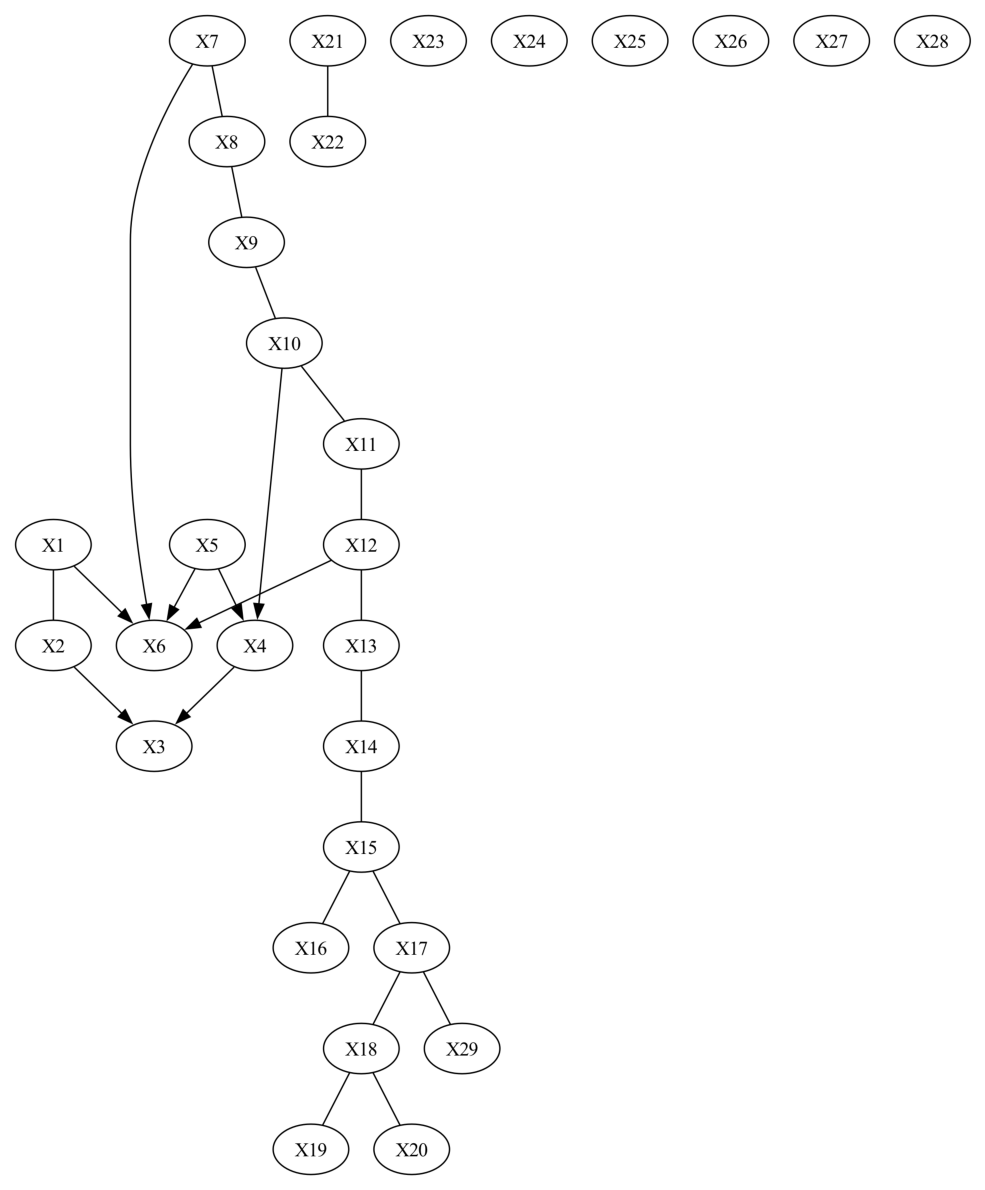

In [296]:
cg = pc(standardized_dataframe.to_numpy(), alpha, indep_test='kci' )
cg.draw_pydot_graph()

In [952]:
adj_mat = cg.graph
adj_mat

array([[ 0,  0, -1, -1, -1,  0,  0, -1,  0,  0,  0,  1,  0,  1,  0,  1,
         0,  0,  0,  1,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  0, -1,  1,  1,  1,  0,  1,  0,  0,  0,  1,  0,  1,  1,
         0,  0,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 1,  0,  0, -1, -1,  1, -1,  0, -1, -1,  0,  0,  1,  1,  1,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  1,  1,  0,  1,  0,  1, -1,  0,  0,  0,  0,  0,  0,  1,  0,
        -1,  1,  0,  1,  0,  0,  0,  0,  0,  0],
       [ 1,  1,  1, -1,  0, -1,  0,  0, -1,  0, -1,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  1,  0,  1,  0,  1, -1,  0, -1,  0, -1,  0,  0,  0,  0,
        -1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, -1,  1, -1,  0,  1,  0,  1, -1,  0,  1,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  1,  0,  1,  1,  0,  1,  0,  0,  0,  1,  0,  0,  0,
         0,  0, -1,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  1,  0,  1,  0, 

In [954]:
graph_nx = nx.from_numpy_array(adj_mat)

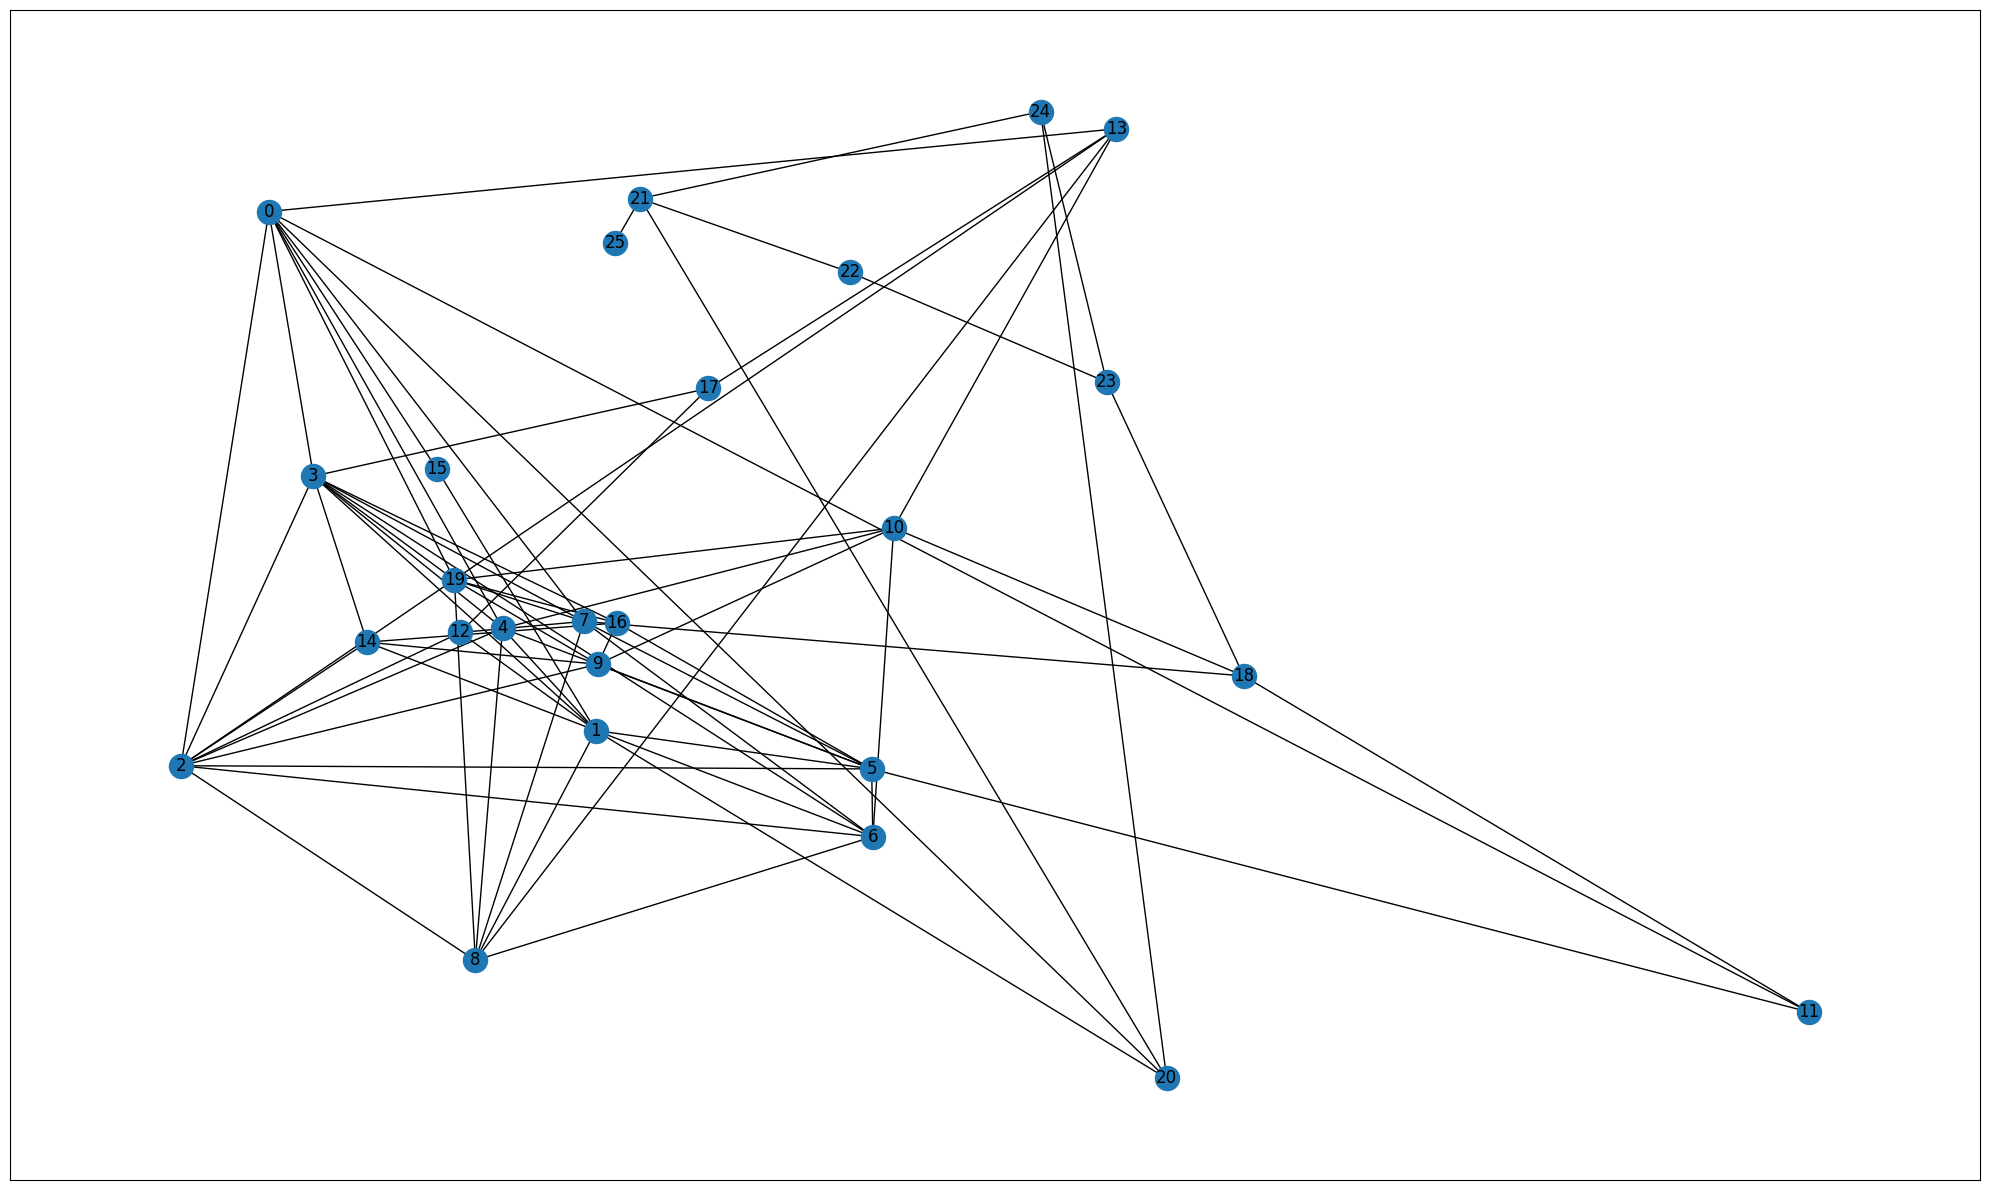

In [955]:
nx.draw_networkx(graph_nx)

In [960]:
ind_edges = graph_nx.edges()

In [1137]:
ind_edges

EdgeView([(0, 2), (0, 3), (0, 4), (0, 7), (0, 11), (0, 13), (0, 15), (0, 19), (0, 20), (1, 3), (1, 4), (1, 5), (1, 6), (1, 8), (1, 12), (1, 14), (1, 15), (1, 20), (2, 3), (2, 4), (2, 5), (2, 6), (2, 8), (2, 9), (2, 12), (2, 13), (2, 14), (3, 4), (3, 6), (3, 7), (3, 14), (3, 16), (3, 17), (3, 19), (4, 5), (4, 8), (4, 10), (5, 6), (5, 7), (5, 9), (5, 11), (5, 16), (6, 7), (6, 8), (6, 10), (7, 8), (7, 12), (7, 18), (7, 19), (8, 13), (8, 19), (9, 10), (9, 14), (9, 16), (9, 19), (10, 13), (10, 18), (10, 19), (11, 18), (12, 17), (13, 17), (14, 16), (16, 19), (18, 23), (20, 21), (20, 24), (21, 22), (21, 24), (21, 25), (22, 23), (23, 24)])

In [959]:
for i in range(0,26): 
    dataframe.rename(columns = {i : f'X{i+1}'},inplace = True)

In [347]:
dataframe.columns

Index(['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11',
       'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21',
       'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29'],
      dtype='object')

In [234]:
columns_retain = ['feature_11','feature_12','feature_14','feature_13','feature_15','feature_16','feature_17','feature_18','Graph Label']

for column in dataframe.columns :
    if column not in columns_retain:
        dataframe.drop(column, axis = 1, inplace = True)

In [235]:
dataframe.head()

feature_11  feature_12  feature_13  feature_14  feature_15  feature_16  \
0   -0.146771   -0.079420    0.007744   -0.077551    0.246403    0.213946   
1    0.251802    0.213217    0.213217    0.000000    0.000000    0.000000   
2    0.246495    0.213217    0.213217    0.000000    0.000000    0.000000   
3   -0.175350   -0.165853   -0.106261    0.009746   -0.078137   -0.146947   
4   -0.049929    0.000000    0.000000    0.000000    0.000000    0.000000   

   feature_17  feature_18  Graph Label  
0    0.213946    0.000000          1.0  
1    0.000000    0.000000          0.0  
2    0.000000    0.000000          0.0  
3    0.246889    0.213217          1.0  
4    0.000000    0.000000          0.0

In [150]:
dataframe['Graph Label'] = dataset.y

In [152]:
dataframe.head()

feature_8  feature_9  feature_10  feature_11  feature_12  feature_13  \
0   0.035332   0.039796    0.039676    0.034916    0.085177    0.033319   
1   0.199149   0.082684    0.085316   -0.010158   -0.072811   -0.072811   
2   0.246926   0.032838    0.085316   -0.010158   -0.072811   -0.072811   
3   0.035470   0.036164    0.035887    0.039917    0.038355    0.081162   
4  -0.010158  -0.072811   -0.072811    0.007661    0.000000    0.000000   

   feature_15  feature_17  Graph Label  
0   -0.009797   -0.072811            1  
1    0.000000    0.000000            0  
2    0.000000    0.000000            0  
3    0.084761   -0.010158            1  
4    0.000000    0.000000            0

In [236]:
xc = dataframe.drop('Graph Label',axis =1)
yc = dataframe['Graph Label']

xc_train,xc_test,yc_train,yc_test = train_test_split(xc,yc, test_size=0.2, random_state=32)

model_c = RandomForestClassifier(n_estimators = 200, criterion='log_loss')
model_c.fit(xc_train,yc_train)

pred = model_c.predict(xc_test)

print(accuracy_score(yc_test,pred))
print(f1_score(yc_test,pred))
print(recall_score(yc_test,pred))

0.8421052631578947
0.8888888888888888
0.8888888888888888


In [268]:
from causallearn.search.ConstraintBased.FCI import fci 

g, edges = fci(standardized_dataframe.to_numpy(),independence_test_method='kci',alpha = 0.05,depth = 2, )

pdy = GraphUtils.to_pydot(g)
pdy.write_png('FCI.png')

Depth=0, working on node 28: 100%|██████████| 29/29 [00:00<00:00, 33.22it/s]


In [ ]:
edges = cg.edges

In [315]:
edges

In [335]:
print(vars(edges[0].node1))

{'name': 'X1', 'node_type': <NodeType.MEASURED: 1>, 'center_x': -1, 'center_y': -1, 'attributes': {}}


In [1063]:
l_edge_list.shape

AttributeError: 'EdgeView' object has no attribute 'shape'

In [334]:
edges[0].node1

In [336]:
edge_list = [(edge.node1.name, edge.node2.name)for edge in edges]

In [337]:
edge_list

[('X1', 'X2'),
 ('X1', 'X6'),
 ('X2', 'X3'),
 ('X3', 'X4'),
 ('X5', 'X4'),
 ('X4', 'X10'),
 ('X5', 'X6'),
 ('X7', 'X6'),
 ('X6', 'X12'),
 ('X8', 'X7'),
 ('X9', 'X8'),
 ('X10', 'X9'),
 ('X11', 'X10'),
 ('X12', 'X11'),
 ('X13', 'X12'),
 ('X13', 'X14'),
 ('X14', 'X15'),
 ('X15', 'X16'),
 ('X15', 'X17'),
 ('X17', 'X18'),
 ('X17', 'X29'),
 ('X18', 'X19'),
 ('X18', 'X20'),
 ('X21', 'X22')]

In [349]:
dataset[0].edge_index

tensor([[ 0,  0,  1,  1,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,  6,  6,  7,  7,
          8,  8,  8,  9,  9,  9, 10, 10, 11, 11, 12, 12, 12, 13, 13, 14, 14, 14,
         15, 16],
        [ 1,  5,  0,  2,  1,  3,  2,  4,  9,  3,  5,  6,  0,  4,  4,  7,  6,  8,
          7,  9, 13,  3,  8, 10,  9, 11, 10, 12, 11, 13, 14,  8, 12, 12, 15, 16,
         14, 14]])

In [396]:
node_to_index = { f'X{i+1}' : i for i in range(0,29)}

In [397]:
node_to_index

{'X1': 0,
 'X2': 1,
 'X3': 2,
 'X4': 3,
 'X5': 4,
 'X6': 5,
 'X7': 6,
 'X8': 7,
 'X9': 8,
 'X10': 9,
 'X11': 10,
 'X12': 11,
 'X13': 12,
 'X14': 13,
 'X15': 14,
 'X16': 15,
 'X17': 16,
 'X18': 17,
 'X19': 18,
 'X20': 19,
 'X21': 20,
 'X22': 21,
 'X23': 22,
 'X24': 23,
 'X25': 24,
 'X26': 25,
 'X27': 26,
 'X28': 27,
 'X29': 28}

In [403]:
indexed_edges = [(node_to_index[edge[0]], node_to_index[edge[1]]) for edge in edge_list]
print(indexed_edges)

[(0, 1), (0, 5), (1, 2), (5, 11), (2, 3), (3, 9), (4, 3), (4, 5), (9, 8), (6, 5), (11, 10), (7, 6), (8, 7), (10, 9), (12, 11), (12, 13), (13, 14), (14, 15), (14, 16), (16, 17), (16, 28), (17, 18), (17, 19), (20, 21)]


In [370]:
print(vars(graph))

{'_edge_attr_cls': <class 'torch_geometric.data.data.DataEdgeAttr'>, '_tensor_attr_cls': <class 'torch_geometric.data.data.DataTensorAttr'>, '_store': {'edge_index': tensor([[ 0,  0,  1,  1,  2,  2,  3,  3,  3,  4,  4,  5,  5,  5,  6,  6,  7,  7,
          8,  8,  8,  9,  9, 10, 10, 10, 11, 11, 11, 12, 12, 13, 13, 13, 14, 15],
        [ 1, 12,  0,  2,  1,  3,  2,  4, 11,  3,  5,  4,  6, 10,  5,  7,  6,  8,
          7,  9, 13,  8, 10,  5,  9, 11,  3, 10, 12,  0, 11,  8, 14, 15, 13, 13]]), 'x': tensor([[1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
       

In [379]:
graph_nx = nx.DiGraph()
graph_nx.add_edges_from(edge_list)

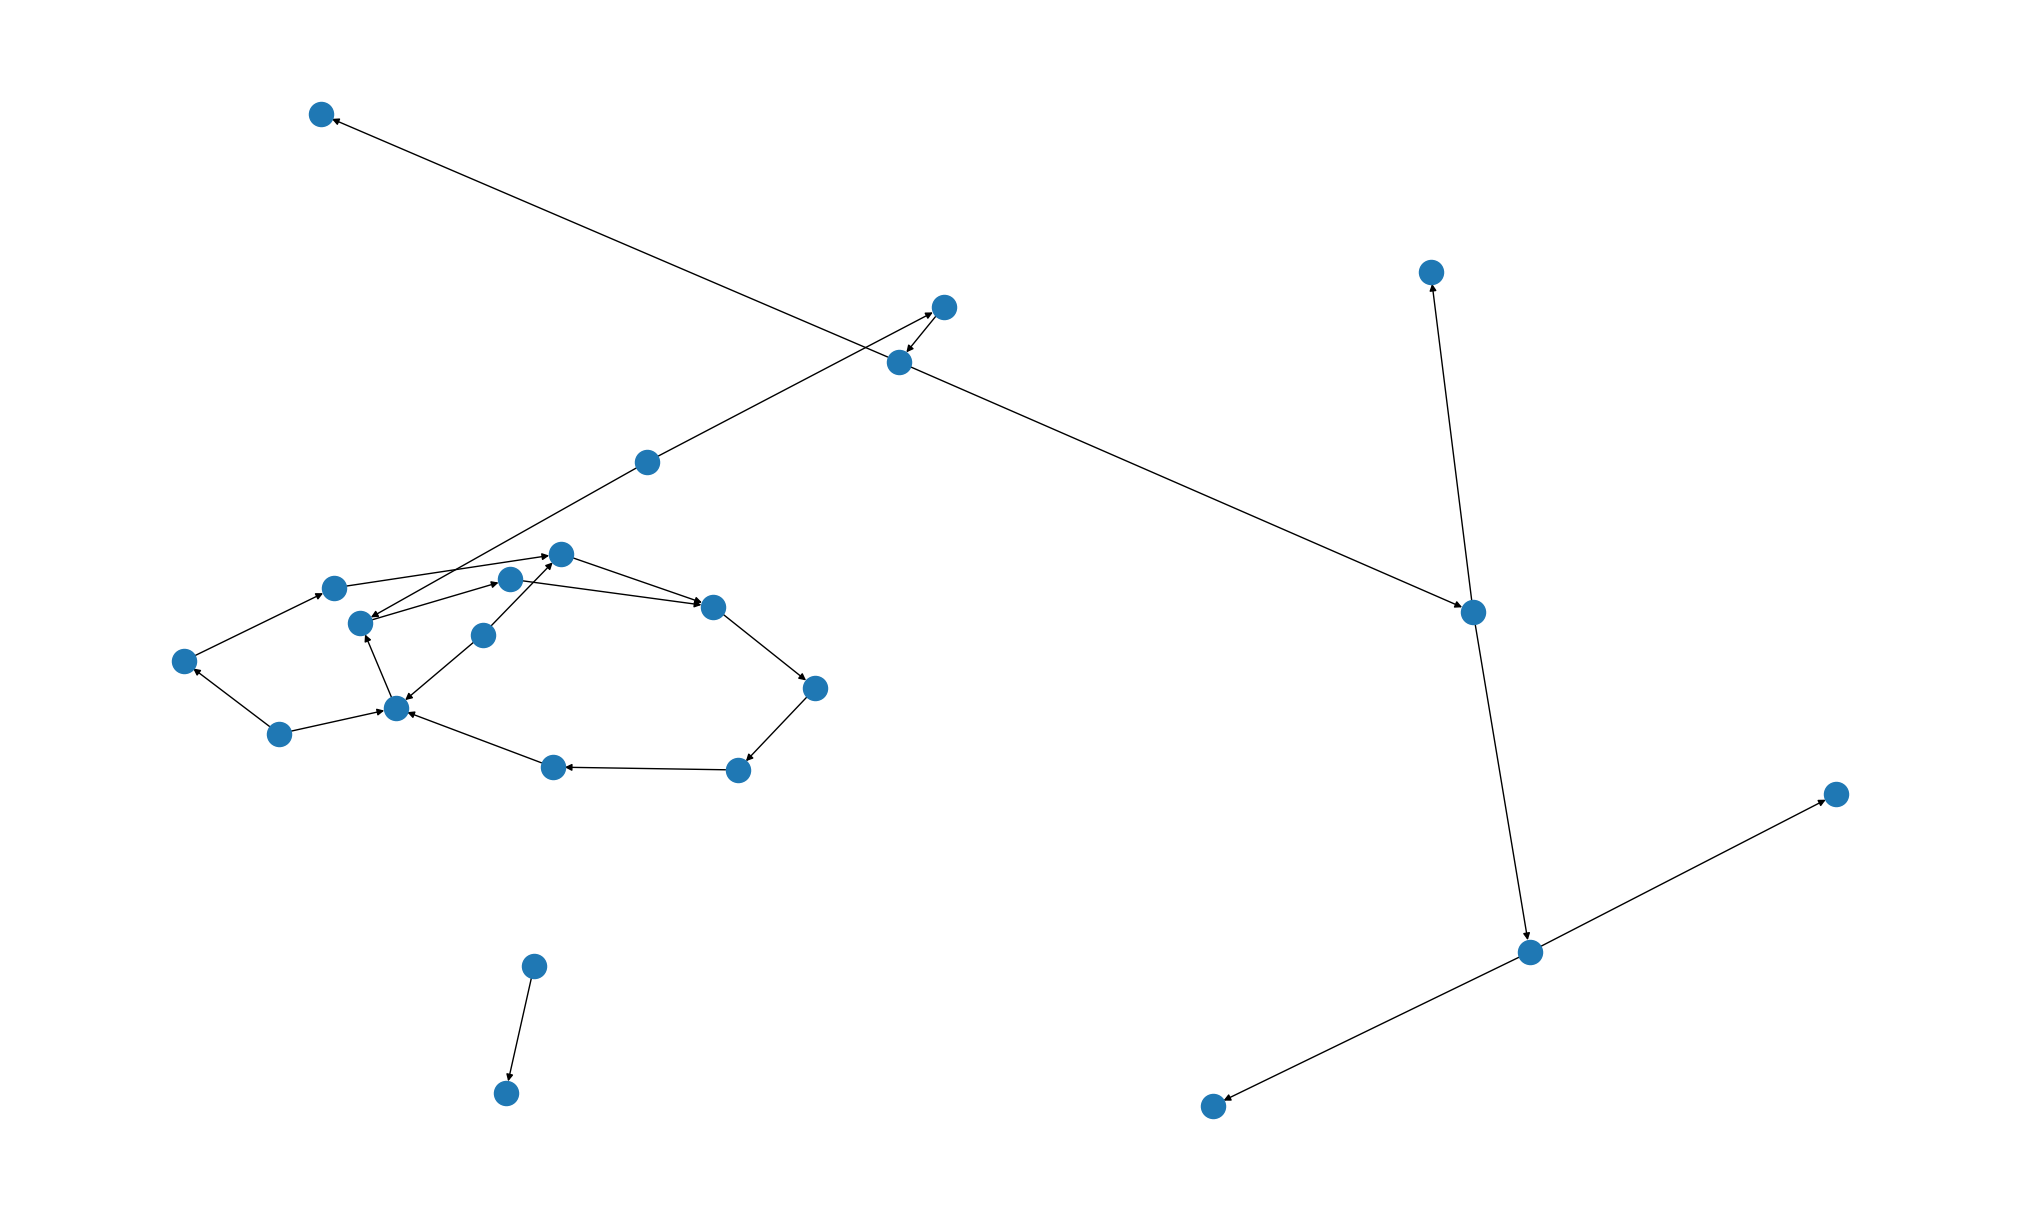

In [380]:
import matplotlib.pyplot as plt
nx.draw(graph_nx)
plt.show()

In [398]:
edge_list = graph_nx.edges

In [384]:
data = pd.DataFrame(graph_data)

In [389]:
for i in range(0,29):
    data.rename(columns= {i: f'X{i+1}'}, inplace = True)

In [390]:
data.head()

X1                                    X2  \
0  tensor(-0.0263, dtype=torch.float32)   tensor(0.0271, dtype=torch.float32)   
1  tensor(-0.0295, dtype=torch.float32)   tensor(0.0033, dtype=torch.float32)   
2   tensor(0.0060, dtype=torch.float32)   tensor(0.0457, dtype=torch.float32)   
3  tensor(-0.0202, dtype=torch.float32)  tensor(-0.0454, dtype=torch.float32)   
4   tensor(0.0274, dtype=torch.float32)   tensor(0.0885, dtype=torch.float32)   

                                     X3                                    X4  \
0   tensor(0.1013, dtype=torch.float32)   tensor(0.0017, dtype=torch.float32)   
1  tensor(-0.0212, dtype=torch.float32)  tensor(-0.0673, dtype=torch.float32)   
2   tensor(0.0246, dtype=torch.float32)  tensor(-0.0114, dtype=torch.float32)   
3  tensor(-0.0900, dtype=torch.float32)  tensor(-0.0968, dtype=torch.float32)   
4   tensor(0.0454, dtype=torch.float32)   tensor(0.0385, dtype=torch.float32)   

                                     X5                                    X6  \
0  tensor(-0.0096, dtype=torch.float32)  tensor(-0.0780, dtype=torch.float32)   
1  tensor(-0.0748, dtype=torch.float32)  tensor(-0.0545, dtype=torch.float32)   
2   tensor(0.0136, dtype=torch.float32)  tensor(-0.0168, dtype=torch.float32)   
3  tensor(-0.0851, dtype=torch.float32)  tensor(-0.0440, dtype=torch.float32)   
4  tensor(-0.0327, dtype=torch.float32)  tensor(-0.0363, dtype=torch.float32)   

                                     X7                                    X8  \
0  tensor(-0.0112, dtype=torch.float32)  tensor(-0.0846, dtype=torch.float32)   
1  tensor(-0.0120, dtype=torch.float32)  tensor(-0.0495, dtype=torch.float32)   
2  tensor(-0.0087, dtype=torch.float32)  tensor(-0.0016, dtype=torch.float32)   
3  tensor(-0.0638, dtype=torch.float32)  tensor(-0.0967, dtype=torch.float32)   
4  tensor(-0.0915, dtype=torch.float32)   tensor(0.0388, dtype=torch.float32)   

                                     X9                                   X10  \
0  tensor(-0.1461, dtype=torch.float32)  tensor(-0.0813, dtype=torch.float32)   
1  tensor(-0.0667, dtype=torch.float32)  tensor(-0.0824, dtype=torch.float32)   
2  tensor(-0.0369, dtype=torch.float32)  tensor(-0.0273, dtype=torch.float32)   
3  tensor(-0.1420, dtype=torch.float32)  tensor(-0.1703, dtype=torch.float32)   
4   tensor(0.0524, dtype=torch.float32)   tensor(0.0103, dtype=torch.float32)   

   ...                                  X19                              X20  \
0  ...      tensor(0., dtype=torch.float32)  tensor(0., dtype=torch.float32)   
1  ...      tensor(0., dtype=torch.float32)  tensor(0., dtype=torch.float32)   
2  ...      tensor(0., dtype=torch.float32)  tensor(0., dtype=torch.float32)   
3  ...  tensor(0.0124, dtype=torch.float32)  tensor(0., dtype=torch.float32)   
4  ...      tensor(0., dtype=torch.float32)  tensor(0., dtype=torch.float32)   

                               X21                              X22  \
0  tensor(0., dtype=torch.float32)  tensor(0., dtype=torch.float32)   
1  tensor(0., dtype=torch.float32)  tensor(0., dtype=torch.float32)   
2  tensor(0., dtype=torch.float32)  tensor(0., dtype=torch.float32)   
3  tensor(0., dtype=torch.float32)  tensor(0., dtype=torch.float32)   
4  tensor(0., dtype=torch.float32)  tensor(0., dtype=torch.float32)   

                               X23                              X24  \
0  tensor(0., dtype=torch.float32)  tensor(0., dtype=torch.float32)   
1  tensor(0., dtype=torch.float32)  tensor(0., dtype=torch.float32)   
2  tensor(0., dtype=torch.float32)  tensor(0., dtype=torch.float32)   
3  tensor(0., dtype=torch.float32)  tensor(0., dtype=torch.float32)   
4  tensor(0., dtype=torch.float32)  tensor(0., dtype=torch.float32)   

                               X25                              X26  \
0  tensor(0., dtype=torch.float32)  tensor(0., dtype=torch.float32)   
1  tensor(0., dtype=torch.float32)  tensor(0., dtype=torch.float32)   
2  tensor(0., dtype=torch.float32)  tensor(0., dtype=t

In [393]:
columns = data.columns 

for col in data.columns : 
    data[col] = data[col].astype(float)

In [394]:
data.head()

X1        X2        X3        X4        X5        X6        X7  \
0 -0.026284  0.027150  0.101298  0.001723 -0.009587 -0.077992 -0.011154   
1 -0.029481  0.003342 -0.021221 -0.067256 -0.074782 -0.054526 -0.012021   
2  0.006011  0.045662  0.024559 -0.011367  0.013623 -0.016820 -0.008672   
3 -0.020236 -0.045436 -0.090045 -0.096770 -0.085068 -0.043995 -0.063793   
4  0.027433  0.088471  0.045427  0.038474 -0.032675 -0.036308 -0.091486   

         X8        X9       X10  ...       X19  X20  X21  X22  X23  X24  X25  \
0 -0.084602 -0.146138 -0.081321  ...  0.000000  0.0  0.0  0.0  0.0  0.0  0.0   
1 -0.049532 -0.066737 -0.082427  ...  0.000000  0.0  0.0  0.0  0.0  0.0  0.0   
2 -0.001614 -0.036918 -0.027325  ...  0.000000  0.0  0.0  0.0  0.0  0.0  0.0   
3 -0.096664 -0.141959 -0.170316  ...  0.012367  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.038835  0.052414  0.010347  ...  0.000000  0.0  0.0  0.0  0.0  0.0  0.0   

   X26  X27  X28  
0  0.0  0.0  0.0  
1  0.0  0.0  0.0  
2  0.0  0.0  0.0  
3  0.0  0.0  0.0  
4  0.0  0.0  0.0  

[5 rows x 28 columns]

In [401]:
edge_list

OutEdgeView([('X1', 'X2'), ('X1', 'X6'), ('X2', 'X3'), ('X6', 'X12'), ('X3', 'X4'), ('X4', 'X10'), ('X5', 'X4'), ('X5', 'X6'), ('X10', 'X9'), ('X7', 'X6'), ('X12', 'X11'), ('X8', 'X7'), ('X9', 'X8'), ('X11', 'X10'), ('X13', 'X12'), ('X13', 'X14'), ('X14', 'X15'), ('X15', 'X16'), ('X15', 'X17'), ('X17', 'X18'), ('X17', 'X29'), ('X18', 'X19'), ('X18', 'X20'), ('X21', 'X22')])

('X1', 'X2')
('X1', 'X6')
('X2', 'X3')
('X6', 'X12')
('X3', 'X4')
('X4', 'X10')
('X5', 'X4')
('X5', 'X6')
('X10', 'X9')
('X7', 'X6')
('X12', 'X11')
('X8', 'X7')
('X9', 'X8')
('X11', 'X10')
('X13', 'X12')
('X13', 'X14')
('X14', 'X15')
('X15', 'X16')
('X15', 'X17')
('X17', 'X18')
('X17', 'X29')
('X18', 'X19')
('X18', 'X20')
('X21', 'X22')


In [408]:
indexed_edges

In [404]:
sample = nx.DiGraph()

sample.add_edges_from(indexed_edges)

In [20]:
nx.draw_networkx(sample, arrows=True , with_labels = True)
plt.show()

NameError: name 'sample' is not defined

In [409]:
sample.edges

OutEdgeView([(0, 1), (0, 5), (1, 2), (5, 11), (2, 3), (11, 10), (3, 9), (9, 8), (4, 3), (4, 5), (8, 7), (6, 5), (10, 9), (7, 6), (12, 11), (12, 13), (13, 14), (14, 15), (14, 16), (16, 17), (16, 28), (17, 18), (17, 19), (20, 21)])

In [410]:
indexed_edge_list = sample.edges

In [1073]:
from torch_geometric.nn import global_mean_pool
class GNNClassifier(nn.Module):
    def __init__(self, input_dim,hidden_dim):
        super(GNNClassifier, self).__init__()
        
        self.conv1 = GCNConv(input_dim, 2* hidden_dim)
        self.conv2 = GCNConv(2*hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.linear1 = nn.Linear(hidden_dim, hidden_dim)
        self.norm1 = nn.BatchNorm1d(hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, 2)
        self.norm2 = nn.BatchNorm1d(hidden_dim)
        
    def forward(self, x , edge_index, edge_attribute,batch ):
        x = self.conv1(x,edge_index, edge_attribute)
        x = F.relu(x)
        x = self.conv2(x,edge_index, edge_attribute)
        x = self.conv3(x,edge_index,edge_attribute)
        x = F.relu(x)
        x = global_mean_pool(x,batch)
        x = self.linear1(x)
        x = self.norm1(x)
        x = self.linear2(x)
        return x 
        
        
        

In [790]:
dataset[0].x.shape

torch.Size([17, 7])

In [415]:
train_data, train_label, test_data, test_label = train_test_split(data,dataset.y, test_size = 0.2)

In [461]:
dataset[0].edge_index

tensor([[ 0,  0,  1,  1,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,  6,  6,  7,  7,
          8,  8,  8,  9,  9,  9, 10, 10, 11, 11, 12, 12, 12, 13, 13, 14, 14, 14,
         15, 16],
        [ 1,  5,  0,  2,  1,  3,  2,  4,  9,  3,  5,  6,  0,  4,  4,  7,  6,  8,
          7,  9, 13,  3,  8, 10,  9, 11, 10, 12, 11, 13, 14,  8, 12, 12, 15, 16,
         14, 14]])

In [969]:
edge_index = torch.tensor([edge for edge in ind_edges])

In [970]:
edge_index

tensor([[ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  7],
        [ 0, 11],
        [ 0, 13],
        [ 0, 15],
        [ 0, 19],
        [ 0, 20],
        [ 1,  3],
        [ 1,  4],
        [ 1,  5],
        [ 1,  6],
        [ 1,  8],
        [ 1, 12],
        [ 1, 14],
        [ 1, 15],
        [ 1, 20],
        [ 2,  3],
        [ 2,  4],
        [ 2,  5],
        [ 2,  6],
        [ 2,  8],
        [ 2,  9],
        [ 2, 12],
        [ 2, 13],
        [ 2, 14],
        [ 3,  4],
        [ 3,  6],
        [ 3,  7],
        [ 3, 14],
        [ 3, 16],
        [ 3, 17],
        [ 3, 19],
        [ 4,  5],
        [ 4,  8],
        [ 4, 10],
        [ 5,  6],
        [ 5,  7],
        [ 5,  9],
        [ 5, 11],
        [ 5, 16],
        [ 6,  7],
        [ 6,  8],
        [ 6, 10],
        [ 7,  8],
        [ 7, 12],
        [ 7, 18],
        [ 7, 19],
        [ 8, 13],
        [ 8, 19],
        [ 9, 10],
        [ 9, 14],
        [ 9, 16],
        [ 9, 19],
        [1

In [485]:
for graph in G:
    if graph.number_of_nodes() != max_nodes:
        diff = max_nodes - graph.number_of_nodes()
        for i in range(diff): 
            graph.add_node((graph.number_of_nodes()+i))
        

In [487]:
G[0].number_of_nodes()

In [490]:
from torch_geometric.utils import from_networkx

print(from_networkx(G[0]))

Data(edge_index=[2, 38], num_nodes=28)


In [491]:
dataset.data

Data(x=[3371, 7], edge_index=[2, 7442], edge_attr=[7442, 4], y=[188])

In [594]:
edge_index

tensor([[ 0,  1],
        [ 0,  5],
        [ 1,  2],
        [ 5, 11],
        [ 2,  3],
        [11, 10],
        [ 3,  9],
        [ 9,  8],
        [ 4,  3],
        [ 4,  5],
        [ 8,  7],
        [ 6,  5],
        [10,  9],
        [ 7,  6],
        [12, 11],
        [12, 13],
        [13, 14],
        [14, 15],
        [14, 16],
        [16, 17],
        [16, 28],
        [17, 18],
        [17, 19],
        [20, 21]])

In [968]:
def padd_graph(graph,diff): 
    padding = np.zeros((diff,10))
    graph_x = graph.x.numpy()
    padded_graph = torch.tensor(np.concatenate((graph_x,padding), axis = 0))
    graph.edge_index = edge_list
    graph.x = padded_graph
    return graph

In [967]:
motif_dataset.data

Data(x=[25000, 10], edge_index=[2, 50960], y=[1000])

In [987]:
dummy_data = motif_dataset.copy()
updated_graphs = []
for graph in dummy_data: 
    if graph.num_nodes != max_nodes:
        diff = max_nodes - graph.num_nodes
        padded_graph = padd_graph(graph, diff)
        updated_graphs.append(padded_graph)
    else :
        updated_graphs.append(graph)

In [988]:
updated_graphs

[Data(x=[25, 10], edge_index=[2, 50], y=[1]),
 Data(x=[25, 10], edge_index=[2, 50], y=[1]),
 Data(x=[25, 10], edge_index=[2, 50], y=[1]),
 Data(x=[25, 10], edge_index=[2, 50], y=[1]),
 Data(x=[25, 10], edge_index=[2, 50], y=[1]),
 Data(x=[25, 10], edge_index=[2, 50], y=[1]),
 Data(x=[25, 10], edge_index=[2, 50], y=[1]),
 Data(x=[25, 10], edge_index=[2, 50], y=[1]),
 Data(x=[25, 10], edge_index=[2, 50], y=[1]),
 Data(x=[25, 10], edge_index=[2, 50], y=[1]),
 Data(x=[25, 10], edge_index=[2, 50], y=[1]),
 Data(x=[25, 10], edge_index=[2, 50], y=[1]),
 Data(x=[25, 10], edge_index=[2, 50], y=[1]),
 Data(x=[25, 10], edge_index=[2, 50], y=[1]),
 Data(x=[25, 10], edge_index=[2, 50], y=[1]),
 Data(x=[25, 10], edge_index=[2, 50], y=[1]),
 Data(x=[25, 10], edge_index=[2, 50], y=[1]),
 Data(x=[25, 10], edge_index=[2, 50], y=[1]),
 Data(x=[25, 10], edge_index=[2, 50], y=[1]),
 Data(x=[25, 10], edge_index=[2, 50], y=[1]),
 Data(x=[25, 10], edge_index=[2, 50], y=[1]),
 Data(x=[25, 10], edge_index=[2, 5

In [973]:
from torch_geometric.data import InMemoryDataset, Data
updated_dataset = Data(x = updated_graphs)

updated_dataset

Data(x=[0])

In [568]:
updated_dataset.x

[Data(edge_index=[2, 38], x=[28, 7], edge_attr=[38, 4], y=[1]),
 Data(edge_index=[2, 28], x=[28, 7], edge_attr=[28, 4], y=[1]),
 Data(edge_index=[2, 28], x=[28, 7], edge_attr=[28, 4], y=[1]),
 Data(edge_index=[2, 44], x=[28, 7], edge_attr=[44, 4], y=[1]),
 Data(edge_index=[2, 22], x=[28, 7], edge_attr=[22, 4], y=[1]),
 Data(edge_index=[2, 34], x=[28, 7], edge_attr=[34, 4], y=[1]),
 Data(edge_index=[2, 44], x=[28, 7], edge_attr=[44, 4], y=[1]),
 Data(edge_index=[2, 26], x=[28, 7], edge_attr=[26, 4], y=[1]),
 Data(edge_index=[2, 38], x=[28, 7], edge_attr=[38, 4], y=[1]),
 Data(edge_index=[2, 38], x=[28, 7], edge_attr=[38, 4], y=[1]),
 Data(edge_index=[2, 46], x=[28, 7], edge_attr=[46, 4], y=[1]),
 Data(edge_index=[2, 50], x=[28, 7], edge_attr=[50, 4], y=[1]),
 Data(edge_index=[2, 28], x=[28, 7], edge_attr=[28, 4], y=[1]),
 Data(edge_index=[2, 44], x=[28, 7], edge_attr=[44, 4], y=[1]),
 Data(edge_index=[2, 50], x=[28, 7], edge_attr=[50, 4], y=[1]),
 Data(edge_index=[2, 22], x=[28, 7], edg

In [576]:
updated_graphs[0]

Data(edge_index=[2, 38], x=[28, 7], edge_attr=[38, 4], y=[1])

In [989]:
updated_dataset = DataLoader(updated_graphs, batch_size=32,shuffle = False)

In [975]:
updated_dataset

TypeError: 'DataLoader' object is not subscriptable

In [985]:
for batch in updated_dataset:
    print(batch[0])
    print(batch.edge_index)

In [983]:
_dataset = DataLoader(dataset, batch_size=32,shuffle = False)

In [1094]:
model = GNNClassifier(10, 64)  # Modify according to your setup
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

def train(model, loader, optimizer, loss_fn):
    
    model.train()
    total_loss = 0 
    correct = 0 
    total = 0
    for epoch in range(300):
        for batch in loader :
            optimizer.zero_grad()
            out = model(batch.x, dummy_index, batch.edge_attr,batch.batch)
            pred = torch.argmax(out, dim = 1)
            print('Pred', pred)
            loss = loss_fn(out,batch.y)
            print(batch.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            correct += (pred==batch.y).sum().item()
            total += batch.y.size(0)
    print('Total Loss ', total_loss)
    print('Total', total)
    print('correct', correct)
    return (total_loss)/len(loader),(correct/total)       
        
        

In [1095]:
loss, accuracy = train(model.float(),updated_dataset,optimizer, loss_fn)

Pred tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
Pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
Pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
Pred tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
Pred tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [1096]:
print(accuracy)

0.46354666666666666


In [976]:
edge_index.shape

torch.Size([71, 2])

In [1083]:
edge_index_l = torch.tensor(l_edge_list, dtype = int)

In [1084]:
dummy_index = edge_index_l.T

In [978]:
dummy_index.shape

torch.Size([2, 71])

In [690]:
for batch in updated_dataset:
    print('A')

A
A
A
A
A
A


In [866]:
print(loss)

35.12205942727987


Processing...
Done!


In [872]:
motif_dataset.data

Data(x=[25000, 10], edge_index=[2, 50960], y=[1000])